### plot FIVES

In [208]:
import torch
from models.unet import UNet
from models.swin_unet import SwinTransformerSys
from models.transunet import TransUNetWithAttention
from models.swinunet import SwinU

from models.vit_seg_modeling import VisionTransformer as ViT_seg
from models.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg

# biuld model

# TransUNet = TransUNetWithAttention(in_ch=3, out_ch=2)
vit_name ='ViT-B_16'
config_vit = CONFIGS_ViT_seg[vit_name]
config_vit.n_classes = 2
config_vit.n_skip = 0
if vit_name.find('R50') != -1:
    config_vit.patches.grid = (int(512 / 16), int(512 / 16))
TransUNet = ViT_seg(config_vit)

safs = UNet(n_classes=2, reduction_ratio=None, n_head = 3, att_mode = 'bam', is_scale_selective = True, is_shortcut = True, conv_type = 'basic')
unet = UNet(n_classes=2, reduction_ratio=None, n_head = 1, att_mode = 'bam', is_scale_selective = False, is_shortcut = True, conv_type = 'basic')
se = UNet(n_classes=2, reduction_ratio=8, n_head = 1, att_mode = 'se', is_scale_selective = False, is_shortcut = True, conv_type = 'basic')
cbam = UNet(n_classes=2, reduction_ratio=8, n_head = 1, att_mode = 'cbam', is_scale_selective = False, is_shortcut = True, conv_type = 'basic')
bam = UNet(n_classes=2, reduction_ratio=8, n_head = 1, att_mode = 'bam', is_scale_selective = False, is_shortcut = True, conv_type = 'basic')
sk = UNet(n_classes=2, reduction_ratio=None, n_head = 1, att_mode = 'bam', is_scale_selective = False, is_shortcut = True, conv_type = 'sk')
sask = UNet(n_classes=2, reduction_ratio=8, n_head = 3, att_mode = 'bam', is_scale_selective = True, is_shortcut = True, conv_type = 'sk')
# saba = UNet(n_classes=2, reduction_ratio=8, n_head = 2, att_mode = 'bam', is_scale_selective = True, is_shortcut = True, conv_type = 'basic')
# swin_unet = SwinTransformerSys(img_size=512, num_classes = 2)
swinunet = SwinU()

# load model
swinunet_path = 'ckpts/SwinUnet-nll-level2-size512-depth5-width32-n_classes2-alpha1-gamma1-nhead2-fold1-100.pkl'
TransUNet_path = 'ckpts/TransUnet-nll-level2-size512-depth5-width32-n_classes2-alpha1-gamma1-nhead2-fold1.pkl'
safs_path = 'ckpts/l20/SAFS-nll+ssim+iou-level2-size512-depth5-width32-n_classes2-nhead3-fold1.pkl'
se_path = 'ckpts/l20/SE-SAFS-nll+ssim+iou-level2-size512-depth5-width32-n_classes2-nhead1-fold1.pkl'
cbam_path = 'ckpts/l20/CBAM-SAFS-nll+ssim+iou-level2-size512-depth5-width32-n_classes2-nhead1-fold1.pkl'
bam_path = 'ckpts/l20/BAM-SAFS-nll+ssim+iou-level2-size512-depth5-width32-n_classes2-nhead1-fold1.pkl'
sk_path = 'ckpts/l20/SK-SAFS-nll+ssim+iou-level2-size512-depth5-width32-n_classes2-nhead1-fold1.pkl'
unet_path = 'ckpts/UNet-nll+ssim+iou-level2-size512-depth5-width32-n_classes2-nhead1-fold1.pkl'
sask_path = 'ckpts/l20/SK-BAM-SAFS-nll+ssim+iou-level2-size512-depth5-width32-n_classes2-nhead3-fold1.pkl'
sask.load_state_dict(torch.load(sask_path))
unet.load_state_dict(torch.load(unet_path))
sk.load_state_dict(torch.load(sk_path))
bam.load_state_dict(torch.load(bam_path))
cbam.load_state_dict(torch.load(cbam_path))
se.load_state_dict(torch.load(se_path))
safs.load_state_dict(torch.load(safs_path))

swinunet.load_state_dict(torch.load(swinunet_path))
TransUNet.load_state_dict(torch.load(TransUNet_path))

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2
---final upsample expand_first---


<All keys matched successfully>

In [171]:
# sask = UNet(n_classes=2, reduction_ratio=8, n_head = 2, att_mode = 'bam', is_scale_selective = True, is_shortcut = True, conv_type = 'sk')
sask_path = 'ckpts/l20/SK-BAM-SAFS-nll+ssim+iou-level2-size512-depth5-width32-n_classes2-nhead3-fold1.pkl'
sask.load_state_dict(torch.load(sask_path))

<All keys matched successfully>

In [3]:
from torchvision import transforms
transform=transforms.Compose([
                                transforms.Resize(512),
                                transforms.ToTensor()
                             ])

In [4]:
import torch

def stitch_patches(patches, grid_rows, grid_cols):
    """
    Args:
        patches: list of 2D tensors [H_patch, W_patch]
        grid_rows: number of rows in the output grid
        grid_cols: number of columns in the output grid
    Returns:
        full_mask: stitched 2D tensor [H_full, W_full]
    """
    H_patch, W_patch = patches[0].shape
    full_mask = torch.zeros((grid_rows * H_patch, grid_cols * W_patch), dtype=patches[0].dtype)

    for idx, patch in enumerate(patches):
        row = idx // grid_cols
        col = idx % grid_cols
        full_mask[
            row * H_patch:(row + 1) * H_patch,
            col * W_patch:(col + 1) * W_patch
        ] = patch

    return full_mask


In [5]:
import torch

def compute_iou(pred_mask, true_mask, eps=1e-6):
    """
    Computes IoU between two binary masks.
    Args:
        pred_mask: tensor of shape [H, W], values 0 or 1
        true_mask: tensor of shape [H, W], values 0 or 1
    Returns:
        iou: float
    """
    pred_mask = pred_mask.bool()
    true_mask = true_mask.bool()
    
    intersection = (pred_mask & true_mask).sum().float()
    union = (pred_mask | true_mask).sum().float()
    
    iou = intersection / (union + eps)
    return iou.item()


In [6]:
from PIL import Image
import os

def crop_image_to_tiles(img_path, tile_size=(512, 512)):
    img = Image.open(img_path)
    img_width, img_height = img.size
    tile_width, tile_height = tile_size
    
    tiles = []
    for top in range(0, img_height, tile_height):
        for left in range(0, img_width, tile_width):
            right = min(left + tile_width, img_width)
            bottom = min(top + tile_height, img_height)
            tile = img.crop((left, top, right, bottom))
            tiles.append(tile)
    return tiles

In [190]:
img_list = ['./datasets/FIVES/test/Original/176_N.png', './datasets/FIVES/test/Original/93_D.png', './datasets/FIVES/test/Original/129_G.png', './datasets/FIVES/test/Original/3_A.png']
img_list = sorted(img_list)
gt_list = []
for img in img_list:
    gt_list.append(img.replace('Original', 'Groundtruth'))

In [191]:
gt_list

['./datasets/FIVES/test/Groundtruth/129_G.png',
 './datasets/FIVES/test/Groundtruth/176_N.png',
 './datasets/FIVES/test/Groundtruth/3_A.png',
 './datasets/FIVES/test/Groundtruth/93_D.png']

In [173]:
import numpy as np
unet = sask
unet.eval()
unet_name = 'sask'
for idx, img_path in enumerate(img_list):
    img_name = os.path.basename(img_path).split('.')[0]

    gt = Image.open(gt_list[idx]).convert("L")
    gt = gt.point(lambda x: 255 if x>100 else 0).convert('1')
    to_tensor = transforms.ToTensor()
    gt = to_tensor(gt)

    tiles = crop_image_to_tiles(img_path)
    masks = []
    for tile in tiles:
        img=transform(tile).unsqueeze(0)
        output, _ = unet(img)
        mask = torch.argmax(output, dim=1).squeeze(0)
        masks.append(mask)
    stitched_mask = stitch_patches(patches=masks, grid_rows=4, grid_cols=4)
    iou = compute_iou(pred_mask=stitched_mask, true_mask=gt.squeeze(0))
    mask_np = stitched_mask.cpu().numpy().astype(np.uint8)* 255  # ensure uint8 for image

    # Save using PIL
    Image.fromarray(mask_np).save("datasets/FIVES/vis/%s_%s_%.2f_mask.png"%(img_name, unet_name, iou*100))

### visualization

In [193]:
vis_root = 'datasets/FIVES/vis/'
unet_list = os.listdir(vis_root)
unet_list = sorted(unet_list)
image_path = []
for p in unet_list:
    exclude_keywords = ['TransUNet','safs', 'se']
    if any(keyword in p for keyword in exclude_keywords):
        continue
    else:
        image_path.append(p)
unet_list=image_path
for i in np.arange(0, len(unet_list), 6):
    # print(i)
    unet_list[i+5], unet_list[i] = unet_list[i], unet_list[i+5]
    unet_list[i+5], unet_list[i+2] = unet_list[i+2], unet_list[i+5]

unet_list

['129_G_unet_76.55_mask.png',
 '129_G_cbam_77.66_mask.png',
 '129_G_bam_77.74_mask.png',
 '129_G_sk_76.21_mask.png',
 '129_G_swinunet_77.47_mask.png',
 '129_G_sask_77.35_mask.png',
 '176_N_unet_80.88_mask.png',
 '176_N_cbam_81.96_mask.png',
 '176_N_bam_82.26_mask.png',
 '176_N_sk_82.08_mask.png',
 '176_N_swinunet_82.75_mask.png',
 '176_N_sask_82.34_mask.png',
 '3_A_unet_87.54_mask.png',
 '3_A_cbam_91.06_mask.png',
 '3_A_bam_90.62_mask.png',
 '3_A_sk_90.28_mask.png',
 '3_A_swinunet_89.27_mask.png',
 '3_A_sask_90.47_mask.png',
 '93_D_unet_80.33_mask.png',
 '93_D_cbam_83.53_mask.png',
 '93_D_bam_82.47_mask.png',
 '93_D_sk_83.20_mask.png',
 '93_D_swinunet_79.85_mask.png',
 '93_D_sask_83.30_mask.png']

In [195]:
path_list = []
for i in range(len(img_list)):
    path_list.append(img_list[i])
    path_list.append(gt_list[i])
    for j in range(6):
        path_list.append(os.path.join(vis_root, unet_list[i*6+j]))
path_list

['./datasets/FIVES/test/Original/129_G.png',
 './datasets/FIVES/test/Groundtruth/129_G.png',
 'datasets/FIVES/vis/129_G_unet_76.55_mask.png',
 'datasets/FIVES/vis/129_G_cbam_77.66_mask.png',
 'datasets/FIVES/vis/129_G_bam_77.74_mask.png',
 'datasets/FIVES/vis/129_G_sk_76.21_mask.png',
 'datasets/FIVES/vis/129_G_swinunet_77.47_mask.png',
 'datasets/FIVES/vis/129_G_sask_77.35_mask.png',
 './datasets/FIVES/test/Original/176_N.png',
 './datasets/FIVES/test/Groundtruth/176_N.png',
 'datasets/FIVES/vis/176_N_unet_80.88_mask.png',
 'datasets/FIVES/vis/176_N_cbam_81.96_mask.png',
 'datasets/FIVES/vis/176_N_bam_82.26_mask.png',
 'datasets/FIVES/vis/176_N_sk_82.08_mask.png',
 'datasets/FIVES/vis/176_N_swinunet_82.75_mask.png',
 'datasets/FIVES/vis/176_N_sask_82.34_mask.png',
 './datasets/FIVES/test/Original/3_A.png',
 './datasets/FIVES/test/Groundtruth/3_A.png',
 'datasets/FIVES/vis/3_A_unet_87.54_mask.png',
 'datasets/FIVES/vis/3_A_cbam_91.06_mask.png',
 'datasets/FIVES/vis/3_A_bam_90.62_mask.p

In [53]:
def image_loader(path_list, idx):
    path = path_list[idx]
    img = Image.open(path)
    # draw = ImageDraw.Draw(img)
    # draw.text((5, 5), "Hello, World!", fill='white')
    return img

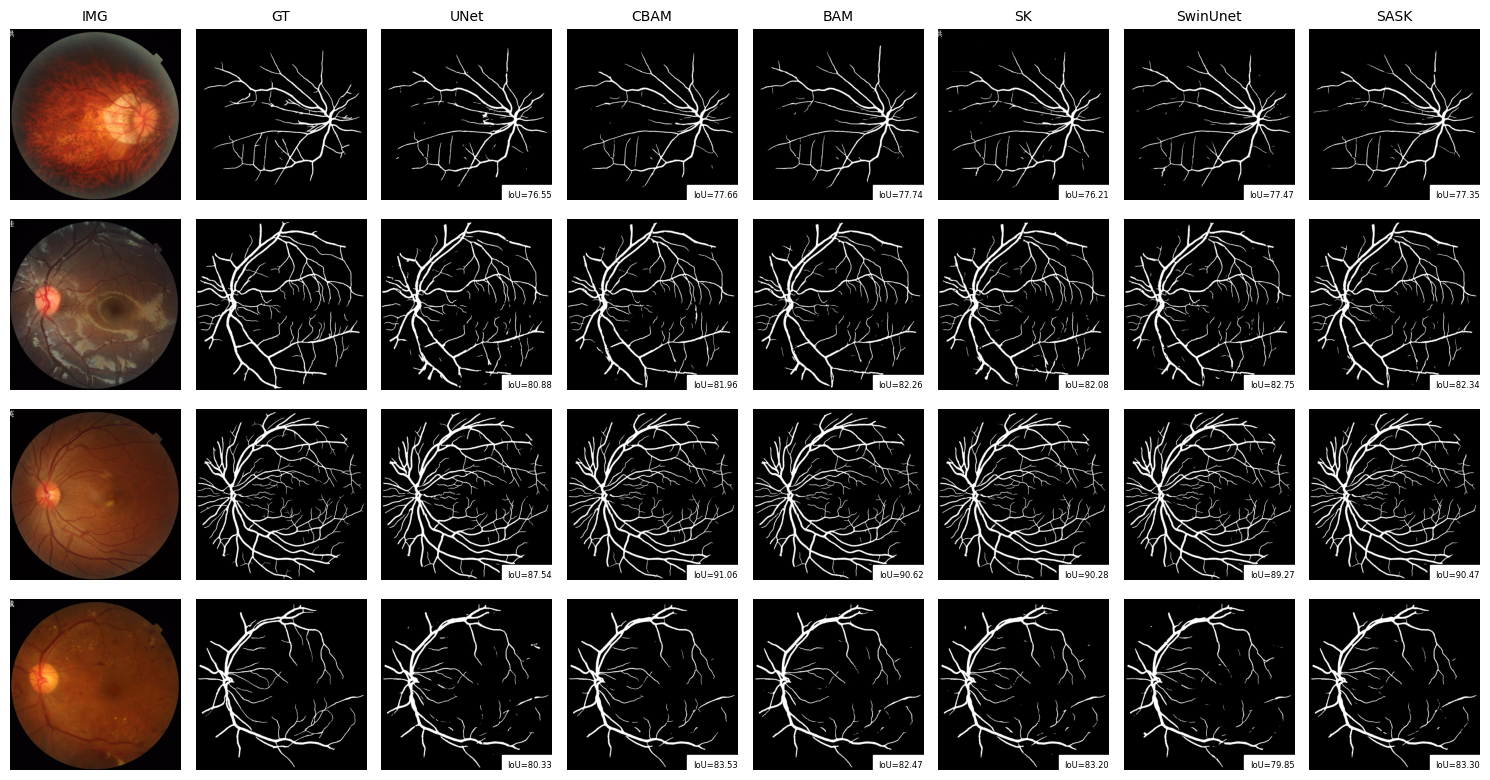

In [198]:
import matplotlib.pyplot as plt

# Example: 32 dummy images (grayscale or RGB)
images = [image_loader(path_list=path_list, idx=i) for i in range(4*8)]  # Replace with your image loading logic
titles = ['IMG', 'GT', 'UNet', 'CBAM', 'BAM', 'SK', 'SwinUnet', 'SASK']

fig, axes = plt.subplots(4, 8, figsize=(15, 8))  # 4 rows, 8 columns

for idx, ax in enumerate(axes.flat):
    j = idx%8
    i = (idx-j)//8
    ax.imshow(images[idx], cmap='gray')  # use cmap='gray' for grayscale
    if j>1:
        iou = float(path_list[idx].split('_')[-2])
        ax.text(1.0, 0.0,  "IoU=%.2f"%iou, color="black", fontsize=6, backgroundcolor='white', ha='right', va='bottom', transform=ax.transAxes)
    ax.axis('off')  # hide axes

    if idx <8:
        ax.set_title(titles[idx], fontsize=10)

plt.tight_layout()
plt.savefig("results/fives_output.png", dpi=300, bbox_inches='tight')
plt.show()

### plot monuseg

In [220]:
root = 'datasets/monuseg/original_testing/vis/'
paths = os.listdir(root)
paths=sorted(paths)
image_path = []
for p in paths:
    exclude_keywords = ['SEU_Net', 'MHU_Net', 'SCU_Net', 'SSU_Net.bmp']
    if any(keyword in p for keyword in exclude_keywords):
        continue
    if p.split('.')[-1] in ['tif', 'bmp']:
        image_path.append(os.path.join(root,p))
image_path

['datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1.tif',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_AttU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_BAMU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_CBAMU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_SKU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_SSU_Netnll+ssim.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_UNet.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_mask.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6.tif',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6_AttU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6_BAMU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6_CBAMU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6_SKU_Ne

In [221]:
for i in np.arange(0, len(image_path), 8):
    # print(i)
    image_path[i+7], image_path[i+1] = image_path[i+1], image_path[i+7]
    image_path[i+6], image_path[i+2] = image_path[i+2], image_path[i+6]
    image_path[i+7], image_path[i+5] = image_path[i+5], image_path[i+7]
    image_path[i+3], image_path[i+4] = image_path[i+4], image_path[i+3]

In [222]:
image_path

['datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1.tif',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_mask.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_UNet.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_SKU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_CBAMU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_AttU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_BAMU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-2Z-A9J9-01A-01-TS1_SSU_Netnll+ssim.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6.tif',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6_mask.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6_UNet.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6_SKU_Net.bmp',
 'datasets/monuseg/original_testing/vis/TCGA-44-2665-01B-06-BS6_CBAMU_Net.bmp',


In [118]:
def get_mask(path):
    gt = Image.open(path).convert("L")
    gt = gt.point(lambda x: 255 if x>100 else 0).convert('1')
    to_tensor = transforms.ToTensor()
    gt = to_tensor(gt)
    return gt

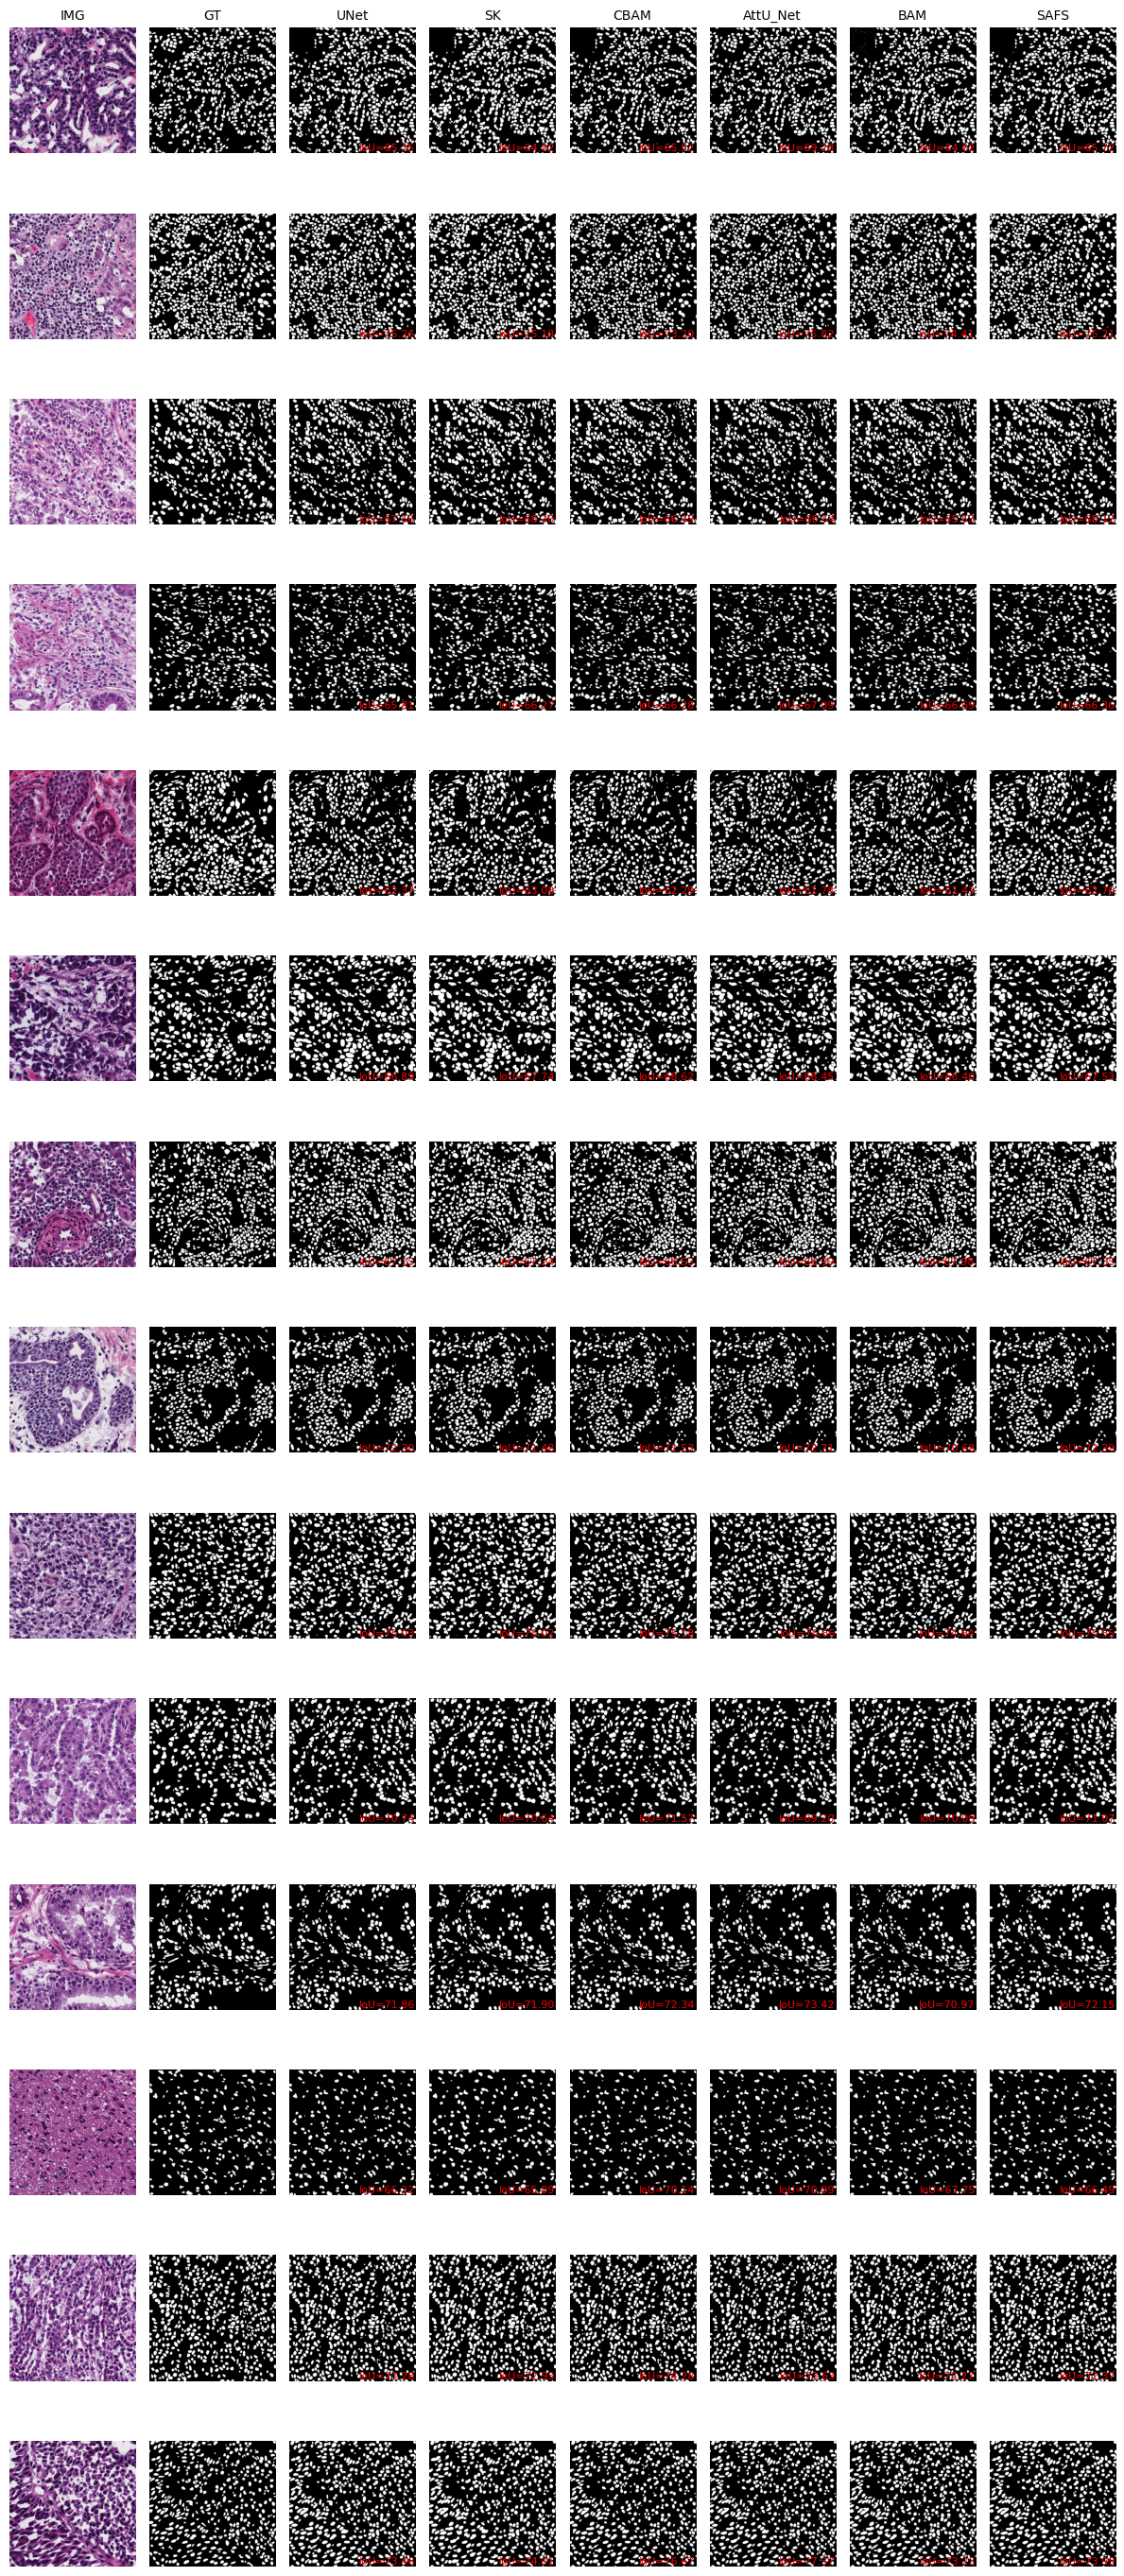

In [223]:
import matplotlib.pyplot as plt

# Example: 32 dummy images (grayscale or RGB)
images = [image_loader(image_path, i) for i in range(0*8, 14*8)]
titles = ['IMG', 'GT','UNet', 'SK','CBAM', 'AttU_Net','BAM', 'SAFS']

fig, axes = plt.subplots(14, 8, figsize=(12, 28))  # 4 rows, 8 columns

for idx, ax in enumerate(axes.flat):
    j = idx%8
    i = (idx-j)//8

    if j==1:
        gt = get_mask(image_path[idx])
    
    ax.imshow(images[idx], cmap='gray')  # use cmap='gray' for grayscale
    if j>1:
        pre_mask = get_mask(image_path[idx])
        iou = compute_iou(pred_mask=pre_mask, true_mask=gt.squeeze(0))
        ax.text(1.0, 0.0,  "IoU=%.2f"%(iou*100), color="red", fontsize=8, ha='right', va='bottom', transform=ax.transAxes)
    ax.axis('off')  # hide axes

    if idx <8:
        ax.set_title(titles[idx], fontsize=10)

plt.tight_layout()
plt.show()


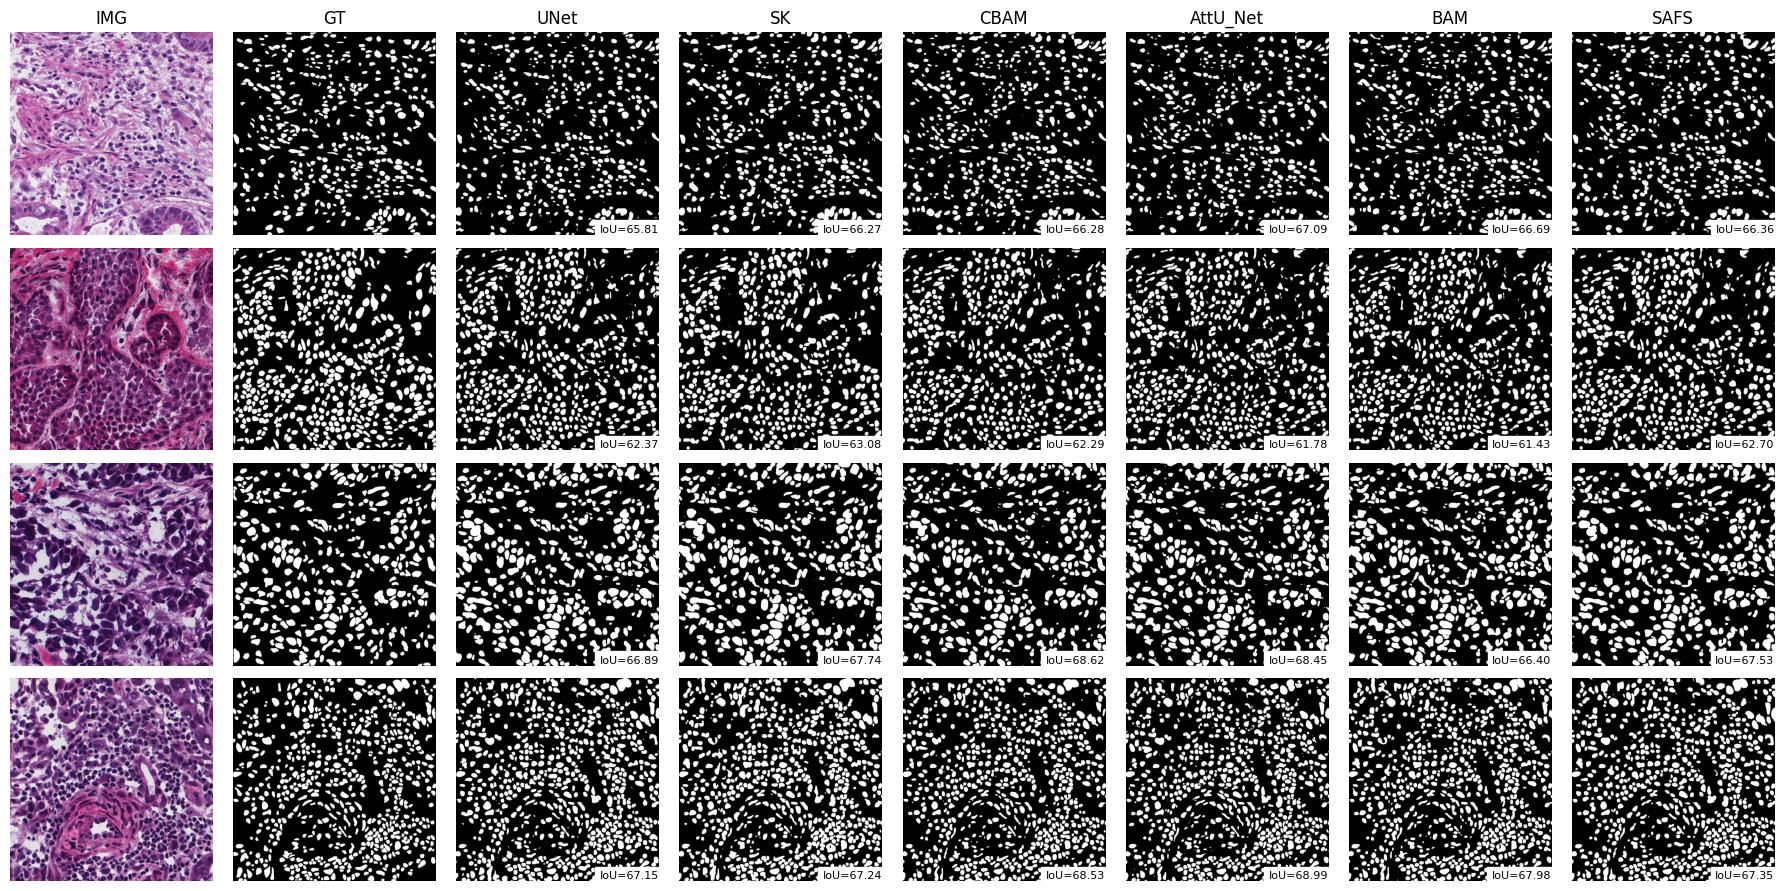

In [229]:
import matplotlib.pyplot as plt

# Example: 32 dummy images (grayscale or RGB)
images = [image_loader(image_path, i) for i in range(3*8, 7*8)]
titles = ['IMG', 'GT','UNet', 'SK','CBAM', 'AttU_Net','BAM', 'SAFS']

fig, axes = plt.subplots(4, 8, figsize=(18, 9))  # 4 rows, 8 columns

for idx, ax in enumerate(axes.flat):
    j = idx%8
    i = (idx-j)//8

    if j==1:
        gt = get_mask(image_path[idx+3*8])
    
    ax.imshow(images[idx], cmap='gray')  # use cmap='gray' for grayscale
    if j>1:
        pre_mask = get_mask(image_path[idx+3*8])
        iou = compute_iou(pred_mask=pre_mask, true_mask=gt.squeeze(0))
        ax.text(1.0, 0.0,  "IoU=%.2f"%(iou*100), color="black", backgroundcolor='white', fontsize=8, ha='right', va='bottom', transform=ax.transAxes)
    ax.axis('off')  # hide axes

    if idx <8:
        ax.set_title(titles[idx], fontsize=12)

plt.tight_layout()
plt.savefig("results/monuseg_output.png", dpi=300, bbox_inches='tight')
plt.show()
